In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [69]:
data = pd.read_excel('cross.xlsx', header = None)
data

,0,1,2,3
0,1945.0,9.0,0.818149,0.000346
1,1537.0,7.0,0.149865,0.679496
2,1.0,1.0,1.000000,1.000000
3,2151.0,5.0,0.453798,0.953450
4,846.0,3.0,0.083470,0.427061
...,...,...,...,...
796,1.0,1.0,1.000000,1.000000
797,654.0,3.0,0.184434,0.513943
798,1.0,1.0,1.000000,1.000000
799,1745.0,3.0,0.313429,0.765969


In [70]:
data = data[data[3]<1]
data = data[data[3]>0]
data

,0,1,2,3
0,1945.0,9.0,0.818149,0.000346
1,1537.0,7.0,0.149865,0.679496
3,2151.0,5.0,0.453798,0.953450
4,846.0,3.0,0.083470,0.427061
6,1554.0,5.0,0.060471,0.610700
...,...,...,...,...
793,784.0,2.0,0.134303,0.531421
794,1135.0,3.0,0.168251,0.556530
795,1002.0,3.0,0.316429,0.699091
797,654.0,3.0,0.184434,0.513943


In [71]:
index = np.arange(1, data.shape[0]+1)
data.set_index(pd.Series(index), inplace=True)
data

,0,1,2,3
1,1945.0,9.0,0.818149,0.000346
2,1537.0,7.0,0.149865,0.679496
3,2151.0,5.0,0.453798,0.953450
4,846.0,3.0,0.083470,0.427061
5,1554.0,5.0,0.060471,0.610700
...,...,...,...,...
617,784.0,2.0,0.134303,0.531421
618,1135.0,3.0,0.168251,0.556530
619,1002.0,3.0,0.316429,0.699091
620,654.0,3.0,0.184434,0.513943


In [72]:
dataset = data.to_numpy()
dataset

array([[1.94500000e+03, 9.00000000e+00, 8.18148554e-01, 3.46191906e-04],
       [1.53700000e+03, 7.00000000e+00, 1.49865442e-01, 6.79495614e-01],
       [2.15100000e+03, 5.00000000e+00, 4.53797709e-01, 9.53449643e-01],
       ...,
       [1.00200000e+03, 3.00000000e+00, 3.16428999e-01, 6.99090674e-01],
       [6.54000000e+02, 3.00000000e+00, 1.84433668e-01, 5.13943109e-01],
       [1.74500000e+03, 3.00000000e+00, 3.13428990e-01, 7.65968744e-01]])

In [73]:
dataset[:,3] = dataset[:,3]*100

In [74]:
def to_XY(dataset):
    x = dataset[:,0:3]
    y = dataset[:,3]

    return np.array(x),np.array(y)

In [75]:
def get_model(num_layers, acti_fun):
    model = Sequential()
    num_neurons = np.random.randint(2, 6, size = num_layers)
    for i in range(num_layers):
        model.add(Dense(num_neurons[i], activation=acti_fun))
    model.add(Dense(1))
    opt = keras.optimizers.Adadelta(learning_rate=0.1)
    model.compile(optimizer=opt, loss='mean_squared_error', metrics= ['accuracy'])
    return model

def evaluate_model(model, trainX, trainY, testX, testY):
    model.fit(trainX, trainY, batch_size=50, verbose = 0, epochs = 15, validation_data= (testX, testY))
    trainPredict = model.predict(trainX)
    testPredict = model.predict(testX)
    trainScore = math.sqrt(mean_squared_error(trainY, trainPredict[:,0]))
    ##print('Train Score: {} RMSE'.format(trainScore))
    testScore = math.sqrt(mean_squared_error(testY, testPredict[:,0]))
    ##print('Test Score: {} RMSE'.format(testScore))
    return trainScore, testScore
    

In [9]:
num_layers = np.random.randint(1, high = 5, size = 5)
activation_fun = ['relu', 'sigmoid', 'softmax', 'tanh', 'swish']
RMSE_matrix_train = np.zeros((len(num_layers), len(activation_fun)))
RMSE_matrix_test = np.zeros((len(num_layers), len(activation_fun)))
RMSE_min_train = 10000.0
RMSE_min_test = 10000.0
final_layers = 0
best_model = []
RMSE_trainsize = []
RMSE_trainsize_test = []
for i in [0.4, 0.5, 0.6, 0.8]:
    train_size = int(len(dataset) * i)
    test_size = len(dataset) - train_size
    train, test = dataset[0:train_size,:], dataset[train_size:len(dataset), :]
    seq_size = 4
    trainX, trainY = to_XY(train)
    testX, testY = to_XY(test)
    for x in range(len(num_layers)):
        for y in range(len(activation_fun)):
            model = get_model(num_layers[x], activation_fun[y])
            trainScore, testScore = evaluate_model(model, trainX, trainY, testX, testY)
            RMSE_matrix_train[x, y] = trainScore
            RMSE_matrix_test[x, y] = testScore
            if(testScore<RMSE_min_test):
                RMSE_min_train = trainScore
                RMSE_min_test = testScore
                final_layers = num_layers[x]
                best_model = model

    print('final number of layers are {}'.format(final_layers))
    final_model = best_model

    trainPredict = final_model.predict(trainX)
    testPredict = final_model.predict(testX)

    trainScore = math.sqrt(mean_squared_error(trainY, trainPredict[:,0]))
    RMSE_trainsize.append(trainScore)
    print('Final Model Train Score for taining size {} % : {} RMSE'.format(i, trainScore))
    testScore = math.sqrt(mean_squared_error(testY, testPredict[:,0]))
    RMSE_trainsize_test.append(testScore)
    print('Final Model Test Score for training size {} % : {} RMSE'.format(i, testScore))

8/8 [==============================] - 0s 2ms/step
final number of layers are 3
8/8 [==============================] - 0s 2ms/step
Final Model Train Score for taining size 0.4 % : 40.278063463545514 RMSE
Final Model Test Score for training size 0.4 % : 40.84735029401993 RMSE
6/6 [==============================] - 0s 2ms/step
final number of layers are 3
6/6 [==============================] - 0s 2ms/step
Final Model Train Score for taining size 0.5 % : 40.59882394363611 RMSE
Final Model Test Score for training size 0.5 % : 40.64417335448101 RMSE
5/5 [==============================] - 0s 2ms/step
final number of layers are 1
5/5 [==============================] - 0s 4ms/step
Final Model Train Score for taining size 0.6 % : 40.75819990309464 RMSE
Final Model Test Score for training size 0.6 % : 40.16749974772632 RMSE
3/3 [==============================] - 0s 4ms/step
final number of layers are 1
3/3 [==============================] - 0s 4ms/step
Final Model Train Score for taining size 0.

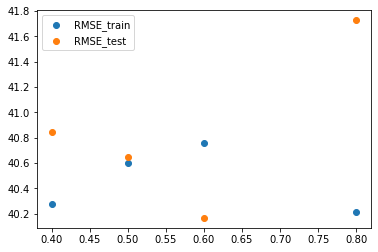

In [10]:
plt.figure()
plt.scatter([0.4, 0.5, 0.6, 0.8], RMSE_trainsize, label="RMSE_train")
plt.scatter([0.4, 0.5, 0.6, 0.8], RMSE_trainsize_test, label="RMSE_test")
plt.legend()

In [78]:
train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset), :]
seq_size = 4
trainX, trainY = to_XY(train)
testX, testY = to_XY(test)
for x in range(len(num_layers)):
    for y in range(len(activation_fun)):
        model = get_model(num_layers[x], activation_fun[y])
        trainScore, testScore = evaluate_model(model, trainX, trainY, testX, testY)
        RMSE_matrix_train[x, y] = trainScore
        RMSE_matrix_test[x, y] = testScore
        if(testScore<RMSE_min_test):
            RMSE_min_train = trainScore
            RMSE_min_test = testScore
            final_layers = num_layers[x]
            best_model = model

print('final number of layers are {}'.format(final_layers))
final_model = best_model

trainPredict = final_model.predict(trainX)
testPredict = final_model.predict(testX)
trainScore = math.sqrt(mean_squared_error(trainY, trainPredict[:,0]))

print('Final Model Train Score for taining size 50 % : {} RMSE'.format( trainScore))
testScore = math.sqrt(mean_squared_error(testY, testPredict[:,0]))

print('Final Model Test Score for training size 50 % : {} RMSE'.format( testScore))

4/4 [==============================] - 0s 2ms/step
final number of layers are 2
4/4 [==============================] - 0s 2ms/step
Final Model Train Score for taining size 50 % : 55.97705587457346 RMSE
Final Model Test Score for training size 50 % : 53.09185397411569 RMSE


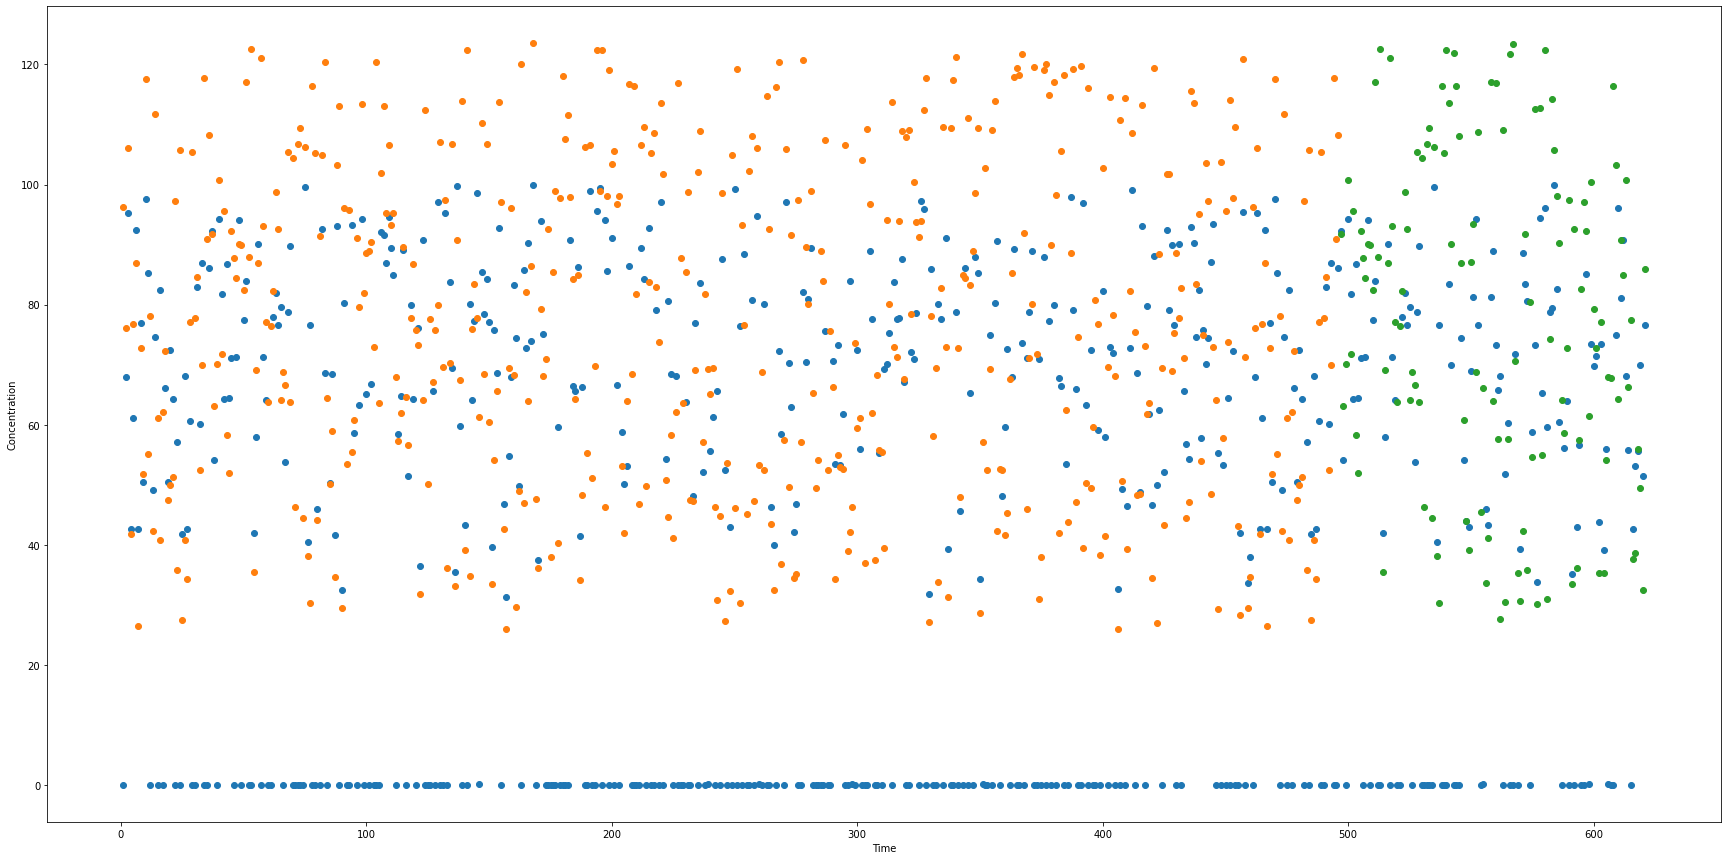

In [79]:
plt.figure(figsize=(30,15))
plt.scatter(np.arange(1, 622),dataset[:,3])
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.scatter(np.arange(1, train_size+1), trainPredict)
plt.scatter(np.arange(train_size+1, 622), testPredict)
plt.show()

In [80]:
model.summary()

Model: "sequential_341"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1158 (Dense)          (None, 2)                 8         
                                                                 
 dense_1159 (Dense)          (None, 1)                 3         
                                                                 
Total params: 11
Trainable params: 11
Non-trainable params: 0
_________________________________________________________________


### Model fitting for counter current flow

In [83]:
counter_data = pd.read_excel('counter_data.xlsx', header=None)
counter_data

,0,1,2,3
0,1898.0,5.0,0.197810,80.793315
1,1988.0,2.0,0.500022,89.611077
2,2310.0,6.0,0.609867,97.610817
3,2219.0,7.0,0.805489,99.603940
4,866.0,7.0,0.239932,85.566232
...,...,...,...,...
635,NaN,NaN,NaN,NaN
636,NaN,NaN,NaN,NaN
637,NaN,NaN,NaN,NaN
638,NaN,NaN,NaN,NaN


In [84]:
counter_data = counter_data[counter_data[3]<100]
counter_data = counter_data[counter_data[3]>0]
counter_data

,0,1,2,3
0,1898.0,5.0,0.197810,80.793315
1,1988.0,2.0,0.500022,89.611077
2,2310.0,6.0,0.609867,97.610817
3,2219.0,7.0,0.805489,99.603940
4,866.0,7.0,0.239932,85.566232
...,...,...,...,...
559,734.0,3.0,0.296676,83.416292
560,1348.0,4.0,0.507858,96.294063
561,1025.0,2.0,0.801015,84.247977
562,2358.0,2.0,0.730331,96.551119


In [85]:
index = np.arange(1, counter_data.shape[0]+1)
counter_data.set_index(pd.Series(index), inplace=True)
counter_data

,0,1,2,3
1,1898.0,5.0,0.197810,80.793315
2,1988.0,2.0,0.500022,89.611077
3,2310.0,6.0,0.609867,97.610817
4,2219.0,7.0,0.805489,99.603940
5,866.0,7.0,0.239932,85.566232
...,...,...,...,...
493,734.0,3.0,0.296676,83.416292
494,1348.0,4.0,0.507858,96.294063
495,1025.0,2.0,0.801015,84.247977
496,2358.0,2.0,0.730331,96.551119


In [86]:
counter_data = counter_data.to_numpy()
counter_data

array([[1.89800000e+03, 5.00000000e+00, 1.97809827e-01, 8.07933146e+01],
       [1.98800000e+03, 2.00000000e+00, 5.00022436e-01, 8.96110767e+01],
       [2.31000000e+03, 6.00000000e+00, 6.09866648e-01, 9.76108175e+01],
       ...,
       [1.02500000e+03, 2.00000000e+00, 8.01014623e-01, 8.42479774e+01],
       [2.35800000e+03, 2.00000000e+00, 7.30330863e-01, 9.65511190e+01],
       [1.65700000e+03, 6.00000000e+00, 2.37283580e-01, 8.52212753e+01]])

In [17]:
num_layers = np.random.randint(1, high = 5, size = 5)
activation_fun = ['relu', 'sigmoid', 'softmax', 'tanh', 'swish']
RMSE_matrix_train = np.zeros((len(num_layers), len(activation_fun)))
RMSE_matrix_test = np.zeros((len(num_layers), len(activation_fun)))
RMSE_min_train = 10000.0
RMSE_min_test = 10000.0
final_layers = 0
best_model = []
RMSE_trainsize = []
RMSE_trainsize_test = []
for i in [0.4, 0.5, 0.6, 0.8]:
    train_size = int(len(counter_data) * i)
    test_size = len(counter_data) - train_size
    train, test = counter_data[0:train_size,:], counter_data[train_size:len(counter_data), :]
    seq_size = 4
    trainX, trainY = to_XY(train)
    testX, testY = to_XY(test)
    for x in range(len(num_layers)):
        for y in range(len(activation_fun)):
            model = get_model(num_layers[x], activation_fun[y])
            trainScore, testScore = evaluate_model(model, trainX, trainY, testX, testY)
            RMSE_matrix_train[x, y] = trainScore
            RMSE_matrix_test[x, y] = testScore
            if(testScore<RMSE_min_test):
                RMSE_min_train = trainScore
                RMSE_min_test = testScore
                final_layers = num_layers[x]
                best_model = model

    print('final number of layers are {}'.format(final_layers))
    final_model = best_model

    trainPredict = final_model.predict(trainX)
    testPredict = final_model.predict(testX)

    trainScore = math.sqrt(mean_squared_error(trainY, trainPredict[:,0]))
    RMSE_trainsize.append(trainScore)
    print('Final Model Train Score for taining size {} % : {} RMSE'.format(i, trainScore))
    testScore = math.sqrt(mean_squared_error(testY, testPredict[:,0]))
    RMSE_trainsize_test.append(testScore)
    print('Final Model Test Score for training size {} % : {} RMSE'.format(i, testScore))

9/9 [==============================] - 0s 3ms/step
final number of layers are 2
9/9 [==============================] - 0s 3ms/step
Final Model Train Score for taining size 0.4 % : 28.348865360771033 RMSE
Final Model Test Score for training size 0.4 % : 29.70172335788188 RMSE
8/8 [==============================] - 0s 2ms/step
final number of layers are 2
8/8 [==============================] - 0s 2ms/step
Final Model Train Score for taining size 0.5 % : 27.343373852866055 RMSE
Final Model Test Score for training size 0.5 % : 27.502425158264586 RMSE
6/6 [==============================] - 0s 3ms/step
final number of layers are 2
6/6 [==============================] - 0s 2ms/step
Final Model Train Score for taining size 0.6 % : 27.580820895498057 RMSE
Final Model Test Score for training size 0.6 % : 27.184588084725952 RMSE
3/3 [==============================] - 0s 2ms/step
final number of layers are 2
3/3 [==============================] - 0s 2ms/step
Final Model Train Score for taining siz

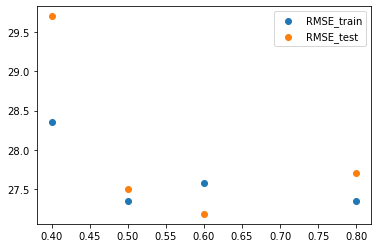

In [18]:
plt.figure()
plt.scatter([0.4, 0.5, 0.6, 0.8], RMSE_trainsize, label="RMSE_train")
plt.scatter([0.4, 0.5, 0.6, 0.8], RMSE_trainsize_test, label="RMSE_test")
plt.legend()

In [89]:
num_layers = np.random.randint(1, high = 3, size = 4)
train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset), :]
seq_size = 4
trainX, trainY = to_XY(train)
testX, testY = to_XY(test)
for x in range(len(num_layers)):
    for y in range(len(activation_fun)):
        model = get_model(num_layers[x], activation_fun[y])
        trainScore, testScore = evaluate_model(model, trainX, trainY, testX, testY)
        RMSE_matrix_train[x, y] = trainScore
        RMSE_matrix_test[x, y] = testScore
        if(testScore<RMSE_min_test):
            RMSE_min_train = trainScore
            RMSE_min_test = testScore
            final_layers = num_layers[x]
            best_model = model

print('final number of layers are {}'.format(final_layers))
final_model = best_model

trainPredict = final_model.predict(trainX)
testPredict = final_model.predict(testX)
trainScore = math.sqrt(mean_squared_error(trainY, trainPredict[:,0]))

print('Final Model Train Score for taining size 50 % : {} RMSE'.format( trainScore))
testScore = math.sqrt(mean_squared_error(testY, testPredict[:,0]))

print('Final Model Test Score for training size 50 % : {} RMSE'.format( testScore))

4/4 [==============================] - 0s 2ms/step
final number of layers are 2
4/4 [==============================] - 0s 1ms/step
Final Model Train Score for taining size 50 % : 55.97705587457346 RMSE
Final Model Test Score for training size 50 % : 53.09185397411569 RMSE


ValueError: x and y must be the same size

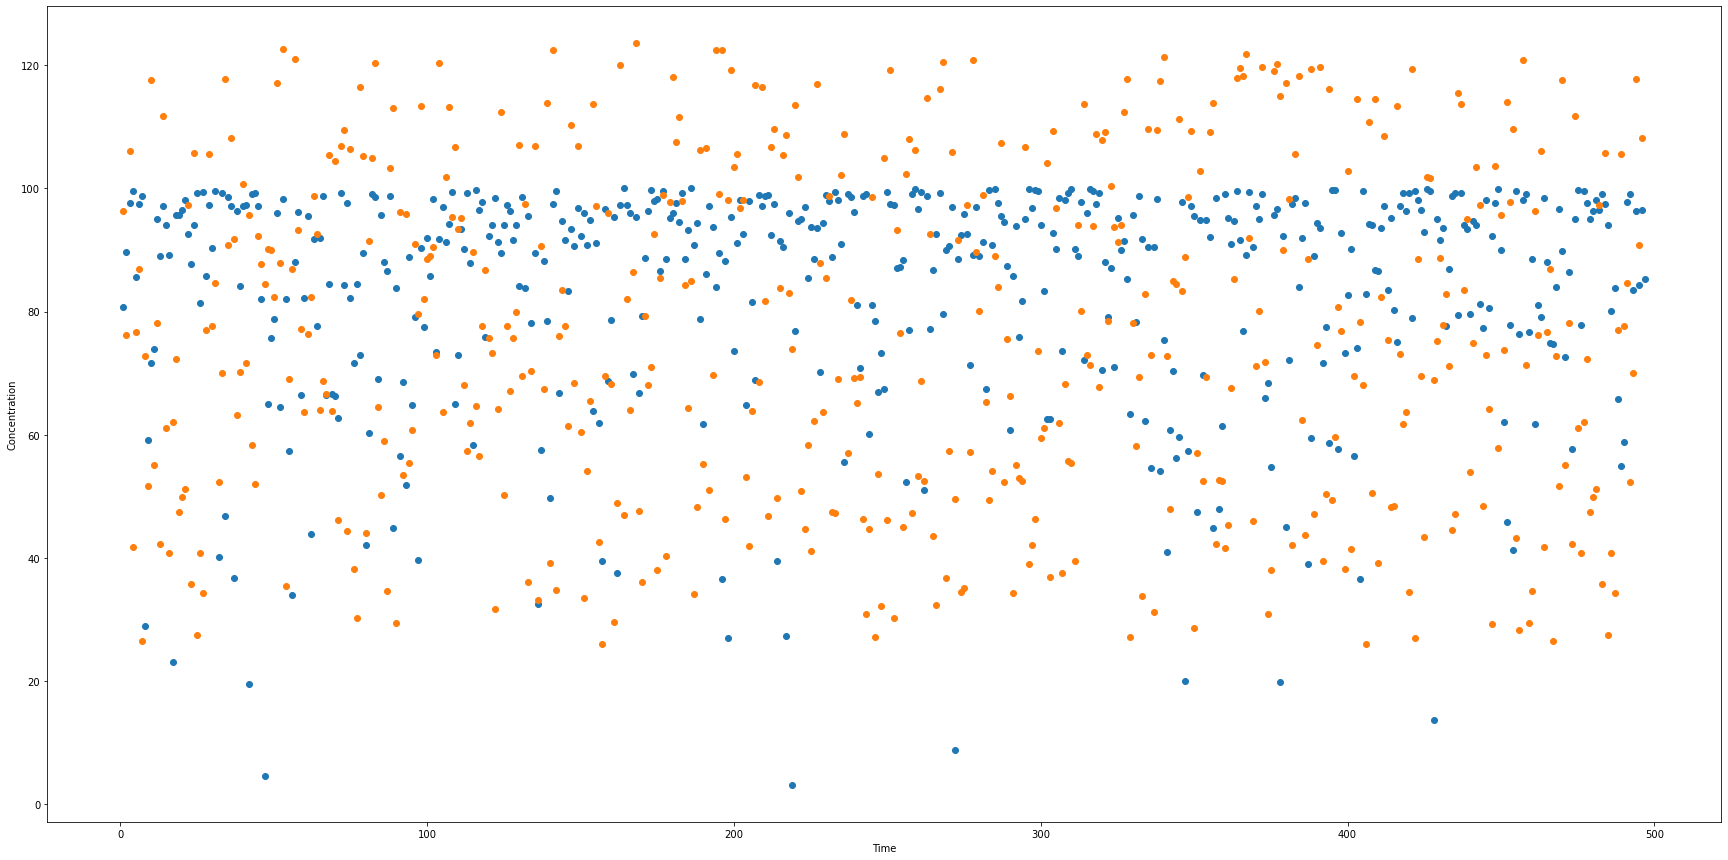

In [98]:
plt.figure(figsize=(30,15))
plt.scatter(np.arange(1, 498),counter_data[:,3])
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.scatter(np.arange(1, train_size+1), trainPredict)
plt.scatter(np.arange(train_size+1, 498), testPredict)
plt.show()

In [99]:
model.summary()

Model: "sequential_401"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1303 (Dense)          (None, 4)                 16        
                                                                 
 dense_1304 (Dense)          (None, 1)                 5         
                                                                 
Total params: 21
Trainable params: 21
Non-trainable params: 0
_________________________________________________________________


In [100]:
xcf = np.array([0.1, 0.25, 0.41, 0.6])
stages = np.array([3,5,7,9])
mesh = np.meshgrid(xcf, stages)

In [101]:
mesh = np.array(mesh)
mesh.shape

(2, 4, 4)

In [102]:
mesh_S = np.zeros((16,3))
for i in range(4):
    for j in range(4):
        mesh_S[4*i+j,:] = np.array([1000, mesh[:,0,2][0], mesh[:,0,2][1]])

In [103]:
mesh_S_predict = final_model.predict(mesh_S)

1/1 [==============================] - 0s 19ms/step


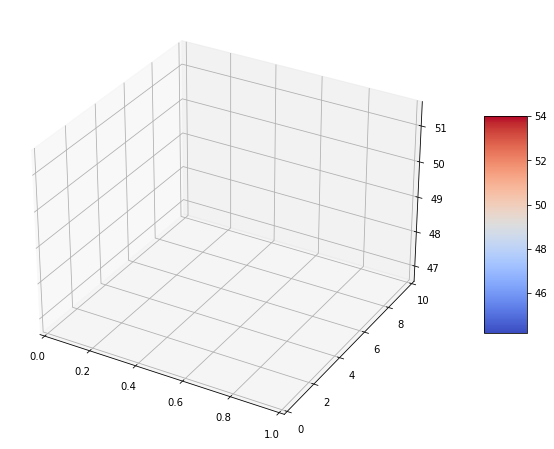

In [104]:
from matplotlib import cm

fig, ax = plt.subplots(subplot_kw={"projection": "3d"},figsize=(15,8))
surf = ax.plot_surface(mesh_S[0], mesh_S[1],mesh_S_predict, cmap=cm.coolwarm)
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.set_xlim(0,1)  
ax.set_ylim(0,10)
plt.show()